## Color data


[INFO] Loading dataset 'bedroom' with feature type 'color'...
  └─ Found 5000 images for class 'real'


Extracting features [real]: 100%|██████████| 5000/5000 [00:02<00:00, 2181.40img/s]


  └─ Found 5000 images for class 'gan'


Extracting features [gan]: 100%|██████████| 5000/5000 [00:02<00:00, 1900.53img/s]


  └─ Found 768 images for class 'diffusion'


Extracting features [diffusion]: 100%|██████████| 768/768 [00:00<00:00, 1946.54img/s]


[INFO] Feature extraction complete. Total samples: 10768. Feature dim: 8448

[INFO] Training Random Forest (binary) on bedroom with color features...
[INFO] Applying SMOTE to balance classes...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


[RESULT] Accuracy: 0.7749
[RESULT] Confusion Matrix:


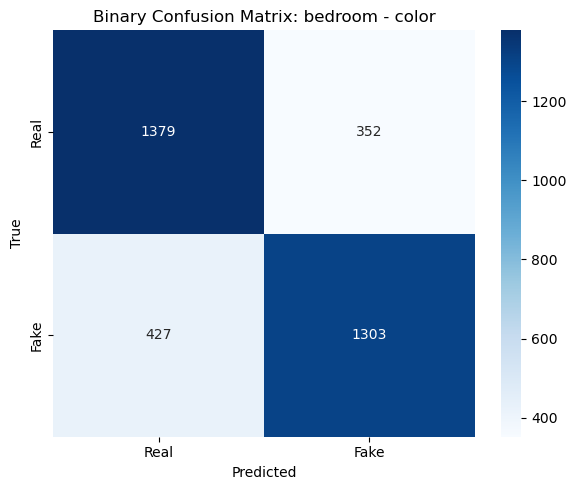


[INFO] Training Random Forest (multiclass) on bedroom with color features...
[INFO] Applying SMOTE to balance classes...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   20.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[RESULT] Accuracy: 0.8131
[RESULT] Confusion Matrix:


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


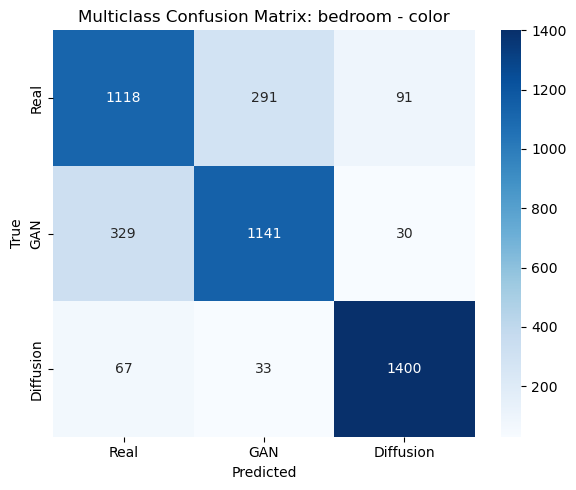

In [22]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# --- Dataset paths ---
DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '/mnt/data/imagenet/real_imagenet',
        'gan': '/mnt/data/imagenet/big_gan',
        'diffusion': '/mnt/data/imagenet/vq_diffusion'
    }
}

# --- Color Feature Extraction ---

def extract_color_features(image_path, bins=(16, 16, 16)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"[WARNING] Failed to read image: {image_path}")
        return None

    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        hist_rgb = cv2.calcHist([image_rgb], [0, 1, 2], None, bins, [0, 256]*3).flatten()
        hist_hsv = cv2.calcHist([image_hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256]).flatten()
        hist_ycrcb = cv2.calcHist([image_ycrcb], [1, 2], None, (16, 16), [0, 256, 0, 256]).flatten()

        return np.concatenate([hist_rgb, hist_hsv, hist_ycrcb])
    except Exception as e:
        print(f"[ERROR] Feature extraction failed for {image_path}: {e}")
        return None

# --- Dataset Loader ---

def load_dataset_features(dataset_name, feature_type='color'):
    print(f"\n[INFO] Loading dataset '{dataset_name}' with feature type '{feature_type}'...")
    dataset = DATASETS[dataset_name]
    features, labels_binary, labels_multiclass = [], [], []

    for label, path in dataset.items():
        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            image_paths.extend(glob(os.path.join(path, ext)))
        print(f"  └─ Found {len(image_paths)} images for class '{label}'")

        for img_path in tqdm(image_paths, desc=f"Extracting features [{label}]", unit="img"):
            if feature_type == 'color':
                feat = extract_color_features(img_path)
            else:
                raise NotImplementedError(f"Feature type '{feature_type}' not implemented.")
            if feat is not None:
                features.append(feat)
                labels_binary.append(0 if label == 'real' else 1)
                labels_multiclass.append({'real': 0, 'gan': 1, 'diffusion': 2}[label])

    print(f"[INFO] Feature extraction complete. Total samples: {len(features)}. Feature dim: {features[0].shape[0] if features else 0}")
    return np.array(features), np.array(labels_binary), np.array(labels_multiclass)

# --- Train and Evaluate with SMOTE ---

def train_evaluate_rf(X, y, task='binary', dataset_name='dataset', feature_type='color'):
    print(f"\n[INFO] Training Random Forest ({task}) on {dataset_name} with {feature_type} features...")

    # ✅ Apply SMOTE before splitting
    print("[INFO] Applying SMOTE to balance classes...")
    sm = SMOTE(random_state=42)
    X, y = sm.fit_resample(X, y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, verbose=1, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Evaluation
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"[RESULT] Accuracy: {acc:.4f}")
    print("[RESULT] Confusion Matrix:")

    labels = ['Real', 'Fake'] if task == 'binary' else ['Real', 'GAN', 'Diffusion']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{task.capitalize()} Confusion Matrix: {dataset_name} - {feature_type}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return clf

# --- Run the pipeline ---

dataset_name = 'bedroom'
feature_type = 'color'

X, y_bin, y_multi = load_dataset_features(dataset_name, feature_type)

clf_bin = train_evaluate_rf(X, y_bin, task='binary', dataset_name=dataset_name, feature_type=feature_type)
clf_multi = train_evaluate_rf(X, y_multi, task='multiclass', dataset_name=dataset_name, feature_type=feature_type)

# LIME for explainable  

## Noise Pattern Analysis

Extracting combined noise features: 100%|██████████| 768/768 [00:04<00:00, 165.58it/s]


[INFO] Applying SMOTE to balance the classes...

=== Random Forest (binary) | bedroom | combined ===
Accuracy: 0.8593


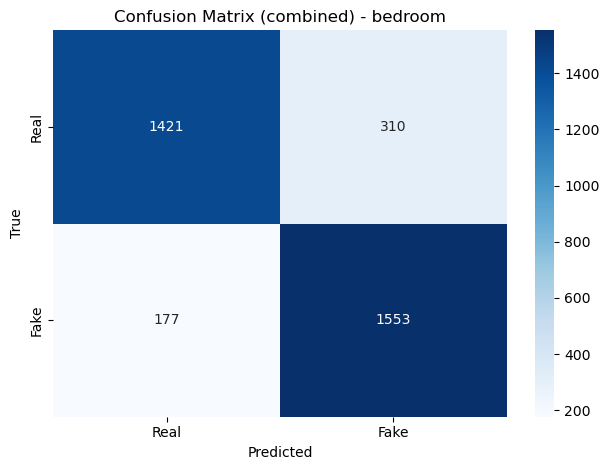

[INFO] Applying SMOTE to balance the classes...

=== Random Forest (multiclass) | bedroom | combined ===
Accuracy: 0.8624


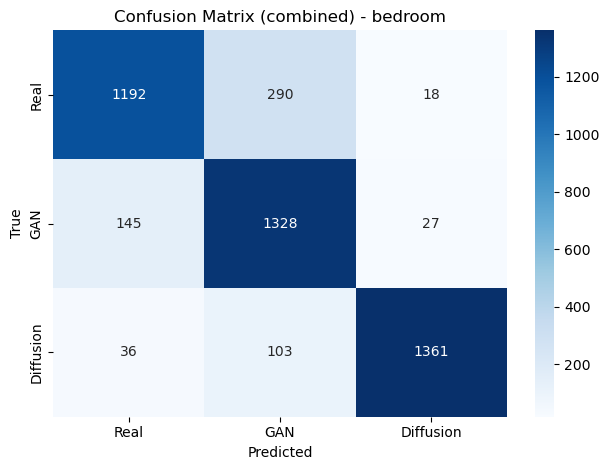

In [2]:
import os
import cv2
import numpy as np
import pywt
from skimage.util import view_as_windows
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from imblearn.over_sampling import SMOTE  # NEW

# Dataset paths
DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '/mnt/data/imagenet/real_imagenet',
        'gan': '/mnt/data/imagenet/big_gan',
        'diffusion': '/mnt/data/imagenet/vq_diffusion'
    }
}

# --- Noise Estimation Functions ---

def estimate_local_noise(image, window_size=7):
    padded_img = np.pad(image, pad_width=window_size//2, mode='reflect')
    windows = view_as_windows(padded_img, (window_size, window_size))
    noise_map = np.std(windows, axis=(2, 3))
    return noise_map

def extract_wavelet_noise(image, wavelet='db1', level=1):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    _, (cH, cV, cD) = coeffs
    noise_energy = np.sqrt(cH**2 + cV**2 + cD**2)
    return noise_energy

# --- Feature Extractors ---

def extract_noise_features_from_folder(folder_path, method='local_noise'):
    features = []
    for img_path in tqdm(glob(os.path.join(folder_path, '*.jpg')), desc=f"Extracting {method}"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0
        try:
            if method == 'local_noise':
                noise_map = estimate_local_noise(img)
            elif method == 'wavelet':
                noise_map = extract_wavelet_noise(img)
            else:
                raise ValueError("Invalid method")
            hist = np.histogram(noise_map.flatten(), bins=64, range=(0, 1), density=True)[0]
            features.append(hist)
        except Exception as e:
            print(f"[ERROR] Skipping {img_path}: {e}")
    return features

def extract_combined_noise_features(image_path, window_size=7, wavelet='db1'):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = img.astype(np.float32) / 255.0
    try:
        local = estimate_local_noise(img, window_size)
        wavelet_energy = extract_wavelet_noise(img, wavelet)
        hist_local = np.histogram(local.flatten(), bins=64, range=(0, 1), density=True)[0]
        hist_wavelet = np.histogram(wavelet_energy.flatten(), bins=64, range=(0, 1), density=True)[0]
        return np.concatenate([hist_local, hist_wavelet])
    except Exception as e:
        print(f"[ERROR] Failed to extract combined features from {image_path}: {e}")
        return None

def extract_combined_noise_features_from_folder(folder_path):
    features = []
    for img_path in tqdm(glob(os.path.join(folder_path, '*.jpg')), desc=f"Extracting combined noise features"):
        feat = extract_combined_noise_features(img_path)
        if feat is not None:
            features.append(feat)
    return features

# --- Load Dataset with Any Noise Method ---

def load_noise_dataset(dataset_dict, method='combined'):
    X, y_bin, y_multi = [], [], []
    label_map = {'real': 0, 'gan': 1, 'diffusion': 2}

    for label, path in dataset_dict.items():
        if method in ['local_noise', 'wavelet']:
            feats = extract_noise_features_from_folder(path, method=method)
        elif method == 'combined':
            feats = extract_combined_noise_features_from_folder(path)
        else:
            raise ValueError(f"Unsupported method: {method}")

        X.extend(feats)
        y_bin.extend([0 if label == 'real' else 1] * len(feats))
        y_multi.extend([label_map[label]] * len(feats))

    return np.array(X), np.array(y_bin), np.array(y_multi)

# --- Train & Evaluate Classifier ---

def train_rf_classifier(X, y, task='binary', dataset_name='dataset', method='local_noise'):
    # Apply SMOTE for class balancing
    print("[INFO] Applying SMOTE to balance the classes...")
    sm = SMOTE(random_state=42)
    X, y = sm.fit_resample(X, y)

    # Split & Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== Random Forest ({task}) | {dataset_name} | {method} ===")
    print(f"Accuracy: {acc:.4f}")
    labels = ['Real', 'Fake'] if task == 'binary' else ['Real', 'GAN', 'Diffusion']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix ({method}) - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return clf

# --- Run Pipeline ---

dataset_name = 'bedroom'  # or 'face', 'imagenet'
method = 'combined'       # options: 'local_noise', 'wavelet', 'combined'

X, y_bin, y_multi = load_noise_dataset(DATASETS[dataset_name], method=method)

# Apply SMOTE + Train
clf_bin = train_rf_classifier(X, y_bin, task='binary', dataset_name=dataset_name, method=method)
clf_multi = train_rf_classifier(X, y_multi, task='multiclass', dataset_name=dataset_name, method=method)

# Frequency Domain Data

Processing FFT features from 'real'...


100%|██████████| 5000/5000 [00:05<00:00, 892.38it/s] 


Processing FFT features from 'gan'...


100%|██████████| 5000/5000 [00:05<00:00, 942.63it/s]


Processing FFT features from 'diffusion'...


100%|██████████| 768/768 [00:00<00:00, 944.18it/s]



[INFO] Training Random Forest (binary) on FFT features for 'bedroom'...
[INFO] Applying SMOTE...
[RESULT] Accuracy: 0.8746


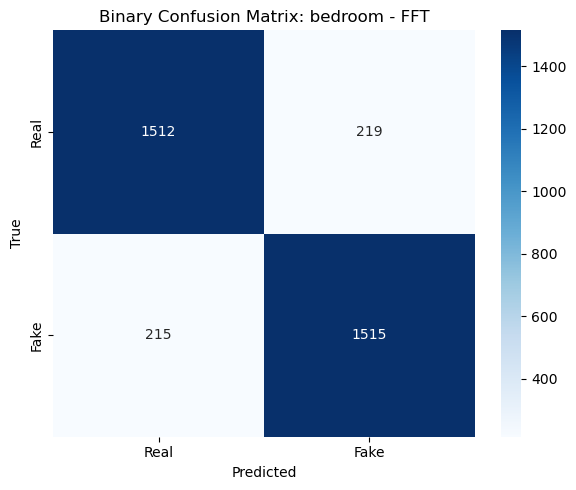


[INFO] Training Random Forest (multiclass) on FFT features for 'bedroom'...
[INFO] Applying SMOTE...
[RESULT] Accuracy: 0.7316


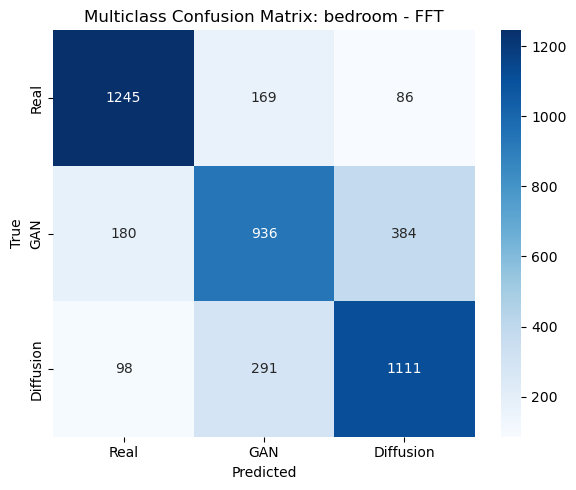

In [23]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.stats import linregress
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Dataset paths
DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '/mnt/data/imagenet/real_imagenet',
        'gan': '/mnt/data/imagenet/big_gan',
        'diffusion': '/mnt/data/imagenet/vq_diffusion'
    }
}

# --- FFT Feature Extraction ---

def compute_fft_features(image, return_profile=False):
    H, W = image.shape
    if np.std(image) < 1e-6:
        return (np.nan, np.nan, None) if return_profile else (np.nan, np.nan)

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])
    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)
    return (-slope, hf_ratio, radial_profile) if return_profile else (-slope, hf_ratio)

# --- Feature Loader ---

def load_fft_dataset(dataset_dict):
    X, y_bin, y_multi = [], [], []
    label_map = {'real': 0, 'gan': 1, 'diffusion': 2}

    for label, folder_path in dataset_dict.items():
        print(f"Processing FFT features from '{label}'...")
        for file_path in tqdm(glob(os.path.join(folder_path, '*.jpg'))):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            slope, hf_ratio, _ = compute_fft_features(img, return_profile=True)
            if not np.isnan(slope) and not np.isnan(hf_ratio):
                X.append([slope, hf_ratio])
                y_bin.append(0 if label == 'real' else 1)
                y_multi.append(label_map[label])
    return np.array(X), np.array(y_bin), np.array(y_multi)

# --- Training with SMOTE ---

def train_fft_rf(X, y, task='binary', dataset_name='dataset'):
    print(f"\n[INFO] Training Random Forest ({task}) on FFT features for '{dataset_name}'...")

    print("[INFO] Applying SMOTE...")
    sm = SMOTE(random_state=42)
    X_bal, y_bal = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"[RESULT] Accuracy: {acc:.4f}")
    labels = ['Real', 'Fake'] if task == 'binary' else ['Real', 'GAN', 'Diffusion']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{task.capitalize()} Confusion Matrix: {dataset_name} - FFT")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return clf

# --- Run Pipeline ---

dataset_name = 'bedroom'
X, y_bin, y_multi = load_fft_dataset(DATASETS[dataset_name])

clf_bin = train_fft_rf(X, y_bin, task='binary', dataset_name=dataset_name)
clf_multi = train_fft_rf(X, y_multi, task='multiclass', dataset_name=dataset_name)

## Texture & Structure Data

Using device: mps
[INFO] Processing real...


100%|██████████| 5000/5000 [00:30<00:00, 162.55it/s]


[INFO] Processing gan...


100%|██████████| 5000/5000 [00:30<00:00, 165.91it/s]


[INFO] Processing diffusion...


100%|██████████| 768/768 [00:04<00:00, 164.36it/s]



[INFO] Training RF on bedroom (binary) with texture+structure features
[INFO] Applying SMOTE for class balancing...
[RESULT] Accuracy: 0.9177


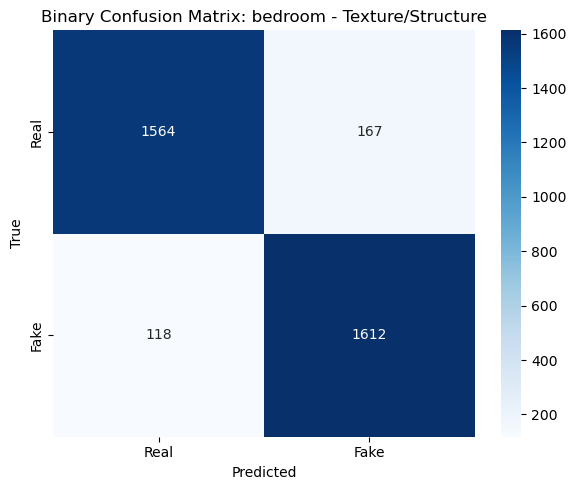


[INFO] Training RF on bedroom (multiclass) with texture+structure features
[INFO] Applying SMOTE for class balancing...
[RESULT] Accuracy: 0.9018


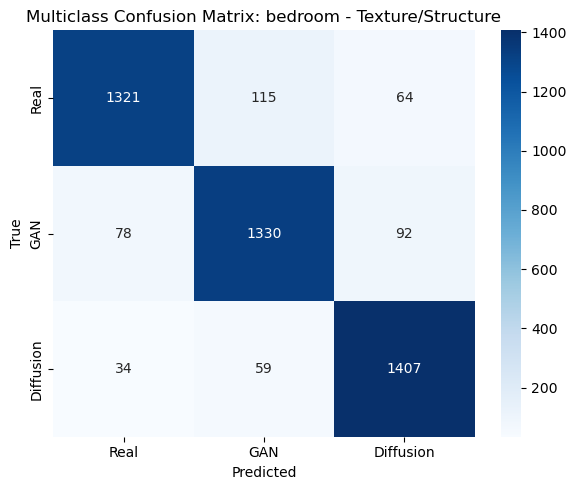

In [24]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from glob import glob
from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from imblearn.over_sampling import SMOTE

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- Dataset Paths ---
DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '/mnt/data/imagenet/real_imagenet',
        'gan': '/mnt/data/imagenet/big_gan',
        'diffusion': '/mnt/data/imagenet/vq_diffusion'
    }
}

# --- Feature Extractors ---

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [graycoprops(glcm, p)[0, 0] for p in props]
    return np.concatenate([lbp_hist, glcm_feats])

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()
        return feat_map.mean(dim=(1, 2)).numpy()
    except Exception as e:
        print(f"Error with {image_path}: {e}")
        return None

# --- Combined Feature Loader (LBP+GLCM + VGG) ---

def load_texture_structure_dataset(dataset_dict):
    X, y_bin, y_multi = [], [], []
    label_map = {'real': 0, 'gan': 1, 'diffusion': 2}

    for label, path in dataset_dict.items():
        print(f"[INFO] Processing {label}...")
        for img_path in tqdm(glob(os.path.join(path, '*.jpg'))):
            try:
                img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_gray is None:
                    continue
                img_gray = img_gray.astype(np.float32) / 255.0
                feat_lbp = extract_lbp_glcm_features(img_gray)

                feat_vgg = extract_vgg_features(img_path)
                if feat_vgg is None:
                    continue

                feat_combined = np.concatenate([feat_lbp, feat_vgg])
                X.append(feat_combined)
                y_bin.append(0 if label == 'real' else 1)
                y_multi.append(label_map[label])
            except Exception as e:
                print(f"  └─ Skipped {img_path}: {e}")

    return np.array(X), np.array(y_bin), np.array(y_multi)

# --- Train & Evaluate Classifier with SMOTE ---

def train_texture_rf(X, y, task='binary', dataset_name='dataset'):
    print(f"\n[INFO] Training RF on {dataset_name} ({task}) with texture+structure features")

    print("[INFO] Applying SMOTE for class balancing...")
    sm = SMOTE(random_state=42)
    X, y = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Real', 'Fake'] if task == 'binary' else ['Real', 'GAN', 'Diffusion']

    print(f"[RESULT] Accuracy: {acc:.4f}")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{task.capitalize()} Confusion Matrix: {dataset_name} - Texture/Structure")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return clf

# --- Run Pipeline ---

dataset_name = 'bedroom'  # or 'face', 'imagenet'

X, y_bin, y_multi = load_texture_structure_dataset(DATASETS[dataset_name])
clf_bin = train_texture_rf(X, y_bin, task='binary', dataset_name=dataset_name)
clf_multi = train_texture_rf(X, y_multi, task='multiclass', dataset_name=dataset_name)

## Pytorch MLP

In [21]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def extract_color_features(image_path, bins=(16, 16, 16)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"[WARNING] Failed to read image: {image_path}")
        return None

    try:
        # Convert to different color spaces
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        # RGB histograms (3D)
        hist_rgb = cv2.calcHist([image_rgb], [0, 1, 2], None, bins, [0, 256]*3).flatten()

        # HSV histograms (3D)
        hist_hsv = cv2.calcHist([image_hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256]).flatten()

        # CbCr histograms (2D)
        hist_ycrcb = cv2.calcHist([image_ycrcb], [1, 2], None, (16, 16), [0, 256, 0, 256]).flatten()

        return np.concatenate([hist_rgb, hist_hsv, hist_ycrcb])
    except Exception as e:
        print(f"[ERROR] Feature extraction failed for {image_path}: {e}")
        return None

def load_dataset_features(dataset_name, feature_type='color'):
    print(f"\n[INFO] Loading dataset '{dataset_name}' with feature type '{feature_type}'...")
    dataset = DATASETS[dataset_name]
    features, labels_binary, labels_multiclass = [], [], []

    for label, path in dataset.items():
        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            image_paths.extend(glob(os.path.join(path, ext)))
        print(f"  └─ Found {len(image_paths)} images for class '{label}'")

        for img_path in tqdm(image_paths, desc=f"Extracting features [{label}]", unit="img"):
            if feature_type == 'color':
                feat = extract_color_features(img_path)
            else:
                raise NotImplementedError(f"Feature type '{feature_type}' not implemented.")
            if feat is not None:
                features.append(feat)
                labels_binary.append(0 if label == 'real' else 1)
                labels_multiclass.append({'real': 0, 'gan': 1, 'diffusion': 2}[label])
            else:
                print(f"[WARNING] Skipped file due to extraction failure: {img_path}")

    if len(features) == 0:
        print("[ERROR] No valid features extracted from dataset.")
        return None, None, None

    return np.array(features), np.array(labels_binary), np.array(labels_multiclass)

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Device selection
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Dataset wrapper
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Deep MLP architecture
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)
    
class WideDeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WideDeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc6 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.3)
        self.act = nn.Mish()

    def forward(self, x):
        x = self.dropout(self.act(self.bn1(self.fc1(x))))
        x = self.dropout(self.act(self.bn2(self.fc2(x))))
        residual = x  # save for residual connection
        x = self.dropout(self.act(self.bn3(self.fc3(x))))
        x = x + residual  # residual connection
        x = self.dropout(self.act(self.bn4(self.fc4(x))))
        x = self.dropout(self.act(self.bn5(self.fc5(x))))
        x = self.dropout(self.act(self.bn6(self.fc6(x))))
        return self.out(x)

# Training loop
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Val Acc: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_mlp_model.pth")
            print("  └─ Best model saved.")

    return y_true, y_pred

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Main entry
def run_mlp_pipeline(X, y, num_classes=3, batch_size=64, val_split=0.3, wide_deep=True):
    dataset = FeatureDataset(X, y)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    if wide_deep:
        model = WideDeepMLP(input_dim=X.shape[1], num_classes=num_classes)
    else:
        model = DeepMLP(input_dim=X.shape[1], num_classes=num_classes)
    y_true, y_pred = train_model(model, train_loader, val_loader)

    class_names = ['Real', 'GAN', 'Diffusion'] if num_classes == 3 else ['Real', 'Fake']
    plot_confusion_matrix(y_true, y_pred, class_names)

    final_acc = accuracy_score(y_true, y_pred)
    print(f"[FINAL ACCURACY] {final_acc:.4f}")
    return model

[INFO] Using device: mps



[INFO] Loading dataset 'face' with feature type 'color'...
  └─ Found 6000 images for class 'real'


Extracting features [real]: 100%|██████████| 6000/6000 [00:06<00:00, 917.60img/s]


  └─ Found 6000 images for class 'gan'


Extracting features [gan]: 100%|██████████| 6000/6000 [00:03<00:00, 1997.60img/s]


  └─ Found 5999 images for class 'diffusion'


Extracting features [diffusion]: 100%|██████████| 5999/5999 [00:02<00:00, 2034.48img/s]


[Epoch 1] Loss: 86.2795 | Val Acc: 0.8300
  └─ Best model saved.
[Epoch 2] Loss: 56.6140 | Val Acc: 0.8587
  └─ Best model saved.
[Epoch 3] Loss: 42.3285 | Val Acc: 0.8659
  └─ Best model saved.
[Epoch 4] Loss: 34.7844 | Val Acc: 0.8731
  └─ Best model saved.
[Epoch 5] Loss: 26.4990 | Val Acc: 0.8729
[Epoch 6] Loss: 23.8845 | Val Acc: 0.8716
[Epoch 7] Loss: 20.7599 | Val Acc: 0.8792
  └─ Best model saved.
[Epoch 8] Loss: 17.3675 | Val Acc: 0.8779
[Epoch 9] Loss: 15.3292 | Val Acc: 0.8748
[Epoch 10] Loss: 14.9672 | Val Acc: 0.8718
[Epoch 11] Loss: 12.1689 | Val Acc: 0.8798
  └─ Best model saved.
[Epoch 12] Loss: 13.0639 | Val Acc: 0.8761
[Epoch 13] Loss: 10.0436 | Val Acc: 0.8870
  └─ Best model saved.
[Epoch 14] Loss: 9.5194 | Val Acc: 0.8779
[Epoch 15] Loss: 10.2379 | Val Acc: 0.8805
[Epoch 16] Loss: 6.9158 | Val Acc: 0.8839
[Epoch 17] Loss: 8.0989 | Val Acc: 0.8787
[Epoch 18] Loss: 8.1158 | Val Acc: 0.8794
[Epoch 19] Loss: 9.0760 | Val Acc: 0.8863
[Epoch 20] Loss: 7.9698 | Val Acc: 0

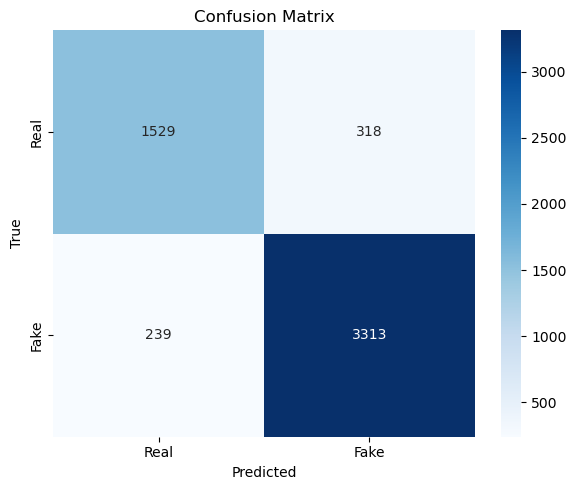

[FINAL ACCURACY] 0.8968
[Epoch 1] Loss: 153.7743 | Val Acc: 0.7162
  └─ Best model saved.
[Epoch 2] Loss: 111.6543 | Val Acc: 0.7448
  └─ Best model saved.
[Epoch 3] Loss: 88.8723 | Val Acc: 0.7605
  └─ Best model saved.
[Epoch 4] Loss: 75.7868 | Val Acc: 0.7664
  └─ Best model saved.
[Epoch 5] Loss: 63.8029 | Val Acc: 0.7664
[Epoch 6] Loss: 54.5719 | Val Acc: 0.7663
[Epoch 7] Loss: 49.0461 | Val Acc: 0.7729
  └─ Best model saved.
[Epoch 8] Loss: 43.2732 | Val Acc: 0.7753
  └─ Best model saved.
[Epoch 9] Loss: 39.0313 | Val Acc: 0.7748
[Epoch 10] Loss: 36.6609 | Val Acc: 0.7768
  └─ Best model saved.
[Epoch 11] Loss: 33.6850 | Val Acc: 0.7837
  └─ Best model saved.
[Epoch 12] Loss: 30.6668 | Val Acc: 0.7792
[Epoch 13] Loss: 27.9652 | Val Acc: 0.7855
  └─ Best model saved.
[Epoch 14] Loss: 26.1408 | Val Acc: 0.7827
[Epoch 15] Loss: 24.3421 | Val Acc: 0.7851
[Epoch 16] Loss: 22.4527 | Val Acc: 0.7816
[Epoch 17] Loss: 21.8158 | Val Acc: 0.7796
[Epoch 18] Loss: 22.1629 | Val Acc: 0.7779
[E

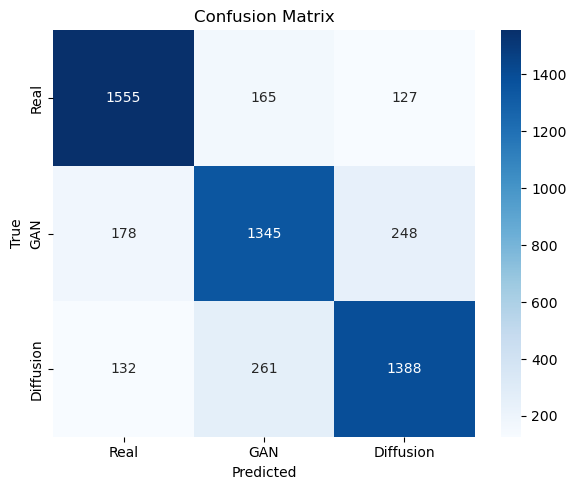

[FINAL ACCURACY] 0.7942


In [23]:
X, y_bin, y_multi = load_dataset_features(dataset_name='face', feature_type='color')

# For binary classification:
model_bin = run_mlp_pipeline(X, y_bin, num_classes=2, wide_deep=False)

# For multiclass classification:
model_multi = run_mlp_pipeline(X, y_multi, num_classes=3, wide_deep=False)

[Epoch 1] Loss: 89.3722 | Val Acc: 0.8385
  └─ Best model saved.
[Epoch 2] Loss: 59.2346 | Val Acc: 0.8529
  └─ Best model saved.
[Epoch 3] Loss: 43.3147 | Val Acc: 0.8629
  └─ Best model saved.
[Epoch 4] Loss: 35.3596 | Val Acc: 0.8672
  └─ Best model saved.
[Epoch 5] Loss: 29.3678 | Val Acc: 0.8776
  └─ Best model saved.
[Epoch 6] Loss: 25.0924 | Val Acc: 0.8702
[Epoch 7] Loss: 22.9702 | Val Acc: 0.8794
  └─ Best model saved.
[Epoch 8] Loss: 19.7728 | Val Acc: 0.8690
[Epoch 9] Loss: 17.0491 | Val Acc: 0.8728
[Epoch 10] Loss: 16.2327 | Val Acc: 0.8896
  └─ Best model saved.
[Epoch 11] Loss: 12.7466 | Val Acc: 0.8798
[Epoch 12] Loss: 13.4161 | Val Acc: 0.8789
[Epoch 13] Loss: 12.2719 | Val Acc: 0.8828
[Epoch 14] Loss: 11.3360 | Val Acc: 0.8724
[Epoch 15] Loss: 11.8920 | Val Acc: 0.8874
[Epoch 16] Loss: 9.7677 | Val Acc: 0.8813
[Epoch 17] Loss: 8.6311 | Val Acc: 0.8841
[Epoch 18] Loss: 9.1821 | Val Acc: 0.8791
[Epoch 19] Loss: 7.9546 | Val Acc: 0.8839
[Epoch 20] Loss: 6.9067 | Val Acc: 

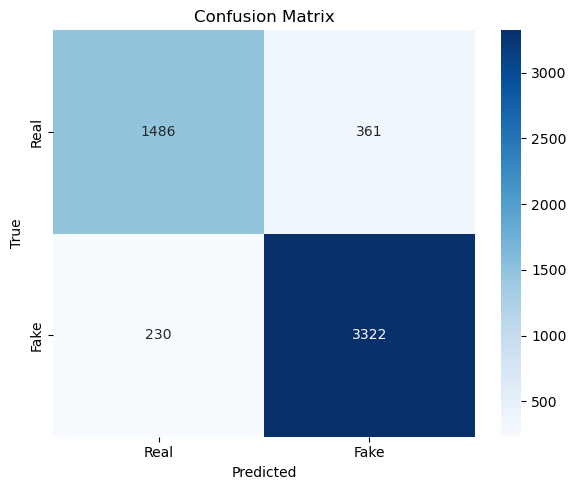

[FINAL ACCURACY] 0.8905
[Epoch 1] Loss: 160.4823 | Val Acc: 0.6912
  └─ Best model saved.
[Epoch 2] Loss: 118.3859 | Val Acc: 0.7477
  └─ Best model saved.
[Epoch 3] Loss: 93.3492 | Val Acc: 0.7622
  └─ Best model saved.
[Epoch 4] Loss: 78.6441 | Val Acc: 0.7607
[Epoch 5] Loss: 67.5618 | Val Acc: 0.7607
[Epoch 6] Loss: 59.1236 | Val Acc: 0.7740
  └─ Best model saved.
[Epoch 7] Loss: 51.1956 | Val Acc: 0.7701
[Epoch 8] Loss: 48.0035 | Val Acc: 0.7748
  └─ Best model saved.
[Epoch 9] Loss: 43.2633 | Val Acc: 0.7633
[Epoch 10] Loss: 36.8336 | Val Acc: 0.7790
  └─ Best model saved.
[Epoch 11] Loss: 34.7387 | Val Acc: 0.7788
[Epoch 12] Loss: 32.3202 | Val Acc: 0.7814
  └─ Best model saved.
[Epoch 13] Loss: 31.6652 | Val Acc: 0.7779
[Epoch 14] Loss: 28.5059 | Val Acc: 0.7868
  └─ Best model saved.
[Epoch 15] Loss: 26.0933 | Val Acc: 0.7827
[Epoch 16] Loss: 23.6428 | Val Acc: 0.7761
[Epoch 17] Loss: 22.9645 | Val Acc: 0.7824
[Epoch 18] Loss: 22.4675 | Val Acc: 0.7807
[Epoch 19] Loss: 20.8282 

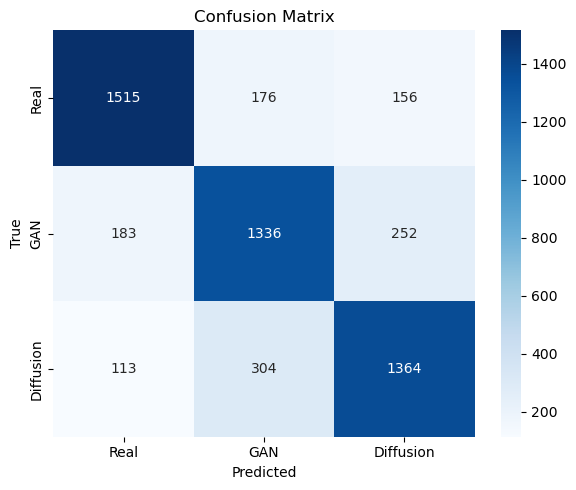

[FINAL ACCURACY] 0.7807


In [24]:
#X, y_bin, y_multi = load_dataset_features(dataset_name='face', feature_type='color')

# For binary classification:
model_bin = run_mlp_pipeline(X, y_bin, num_classes=2)

# For multiclass classification:
model_multi = run_mlp_pipeline(X, y_multi, num_classes=3)